In [106]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



In [107]:
USE_GPU = True
TRAIN = True

In [108]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1726597935.052133  192203 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726597935.054430  192203 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726597935.056134  192203 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726597935.058483  192203 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [109]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 32
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
CRITIC_LEARNING_RATE = 0.00001
GENERATOR_LEARNING_RATE = 0.00001
EPOCHS = 100
CRITIC_STEPS = 5
GP_WEIGHT = 9.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100
STEPS_PER_EPOCH = 5
REPEAT_DATA = 5

In [110]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((852, 188), (852, 2), (188, 2), (852, 14, 14, 1), 196)

In [111]:
critic = Sequential(
    [
        Input(shape=X.shape[1:]),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 7, 7, 14)       │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 7, 7, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 4, 4, 28)       │         3,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 2, 2, 56)       │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 1, 1, 112)      │        56,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 1, 1, 196)      │        88,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 196)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,428 (634.48 KB)

 Trainable params: 162,428 (634.48 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
        ),
        layers.Reshape(X.shape[1:]),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_14 (Reshape)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_35             │ (None, 4, 4, 196)      │       614,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 4, 4, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 2, 2, 112)      │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 1, 1, 56)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_76 (LeakyReLU)      │ (None, 1, 1, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_36             │ (None, 2, 2, 28)       │        25,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_77 (LeakyReLU)      │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 2, 2, 28)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 2, 2, 28)       │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_78 (LeakyReLU)      │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 1, 1, 56)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │             

 Total params: 1,810,676 (6.91 MB)

 Trainable params: 1,810,172 (6.91 MB)

 Non-trainable params: 504 (1.97 KB)

In [113]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [114]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [115]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - c_gp: 0.3974 - c_loss: 3.5786 - c_wass_loss: 0.0017 - g_loss: -0.0021

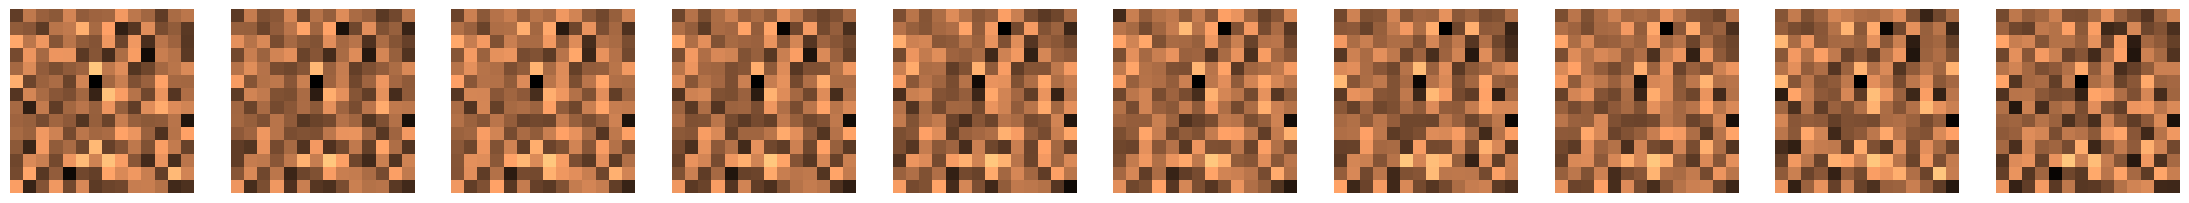

5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - c_gp: 0.3962 - c_loss: 3.5678 - c_wass_loss: 0.0017 - g_loss: -0.0021
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.3606 - c_loss: 3.2475 - c_wass_loss: 0.0017 - g_loss: -0.0022
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/100


2024-09-17 19:33:05.649495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7144270009558378177
/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.3167 - c_loss: 2.8525 - c_wass_loss: 0.0018 - g_loss: -0.0024
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.2784 - c_loss: 2.5078 - c_wass_loss: 0.0018 - g_loss: -0.0025
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.2338 - c_loss: 2.1056 - c_wass_loss: 0.0017 - g_loss: -0.0026
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.1910 - c_loss: 1.7208 - c_wass_loss: 0.0017 - g_loss: -0.0028

2024-09-17 19:33:06.360239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7144270009558378177


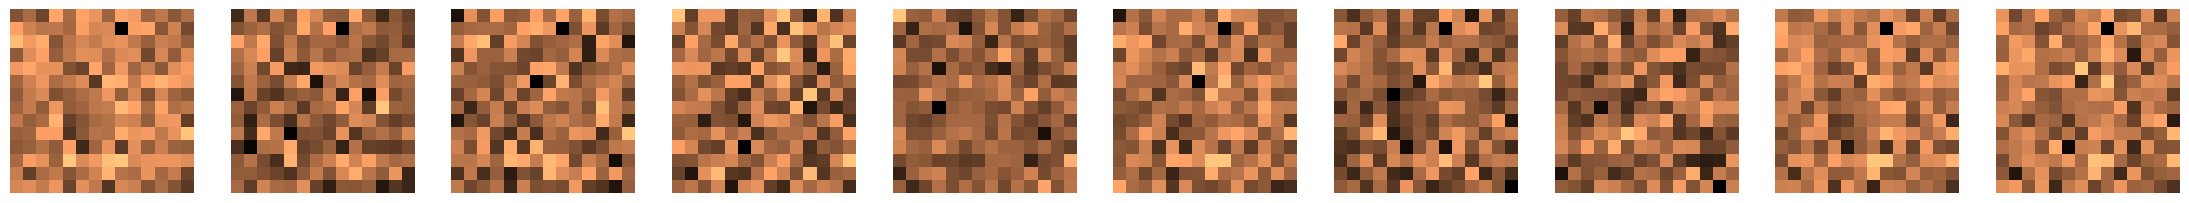

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - c_gp: 0.1900 - c_loss: 1.7117 - c_wass_loss: 0.0017 - g_loss: -0.0028
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.1503 - c_loss: 1.3540 - c_wass_loss: 0.0017 - g_loss: -0.0029
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.1139 - c_loss: 1.0268 - c_wass_loss: 0.0017 - g_loss: -0.0031
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/100


2024-09-17 19:33:06.825449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7144270009558378177


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0865 - c_loss: 0.7799 - c_wass_loss: 0.0016 - g_loss: -0.0033
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - c_gp: 0.0614 - c_loss: 0.5538 - c_wass_loss: 0.0016 - g_loss: -0.0034
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0500 - c_loss: 0.4518 - c_wass_loss: 0.0016 - g_loss: -0.0035

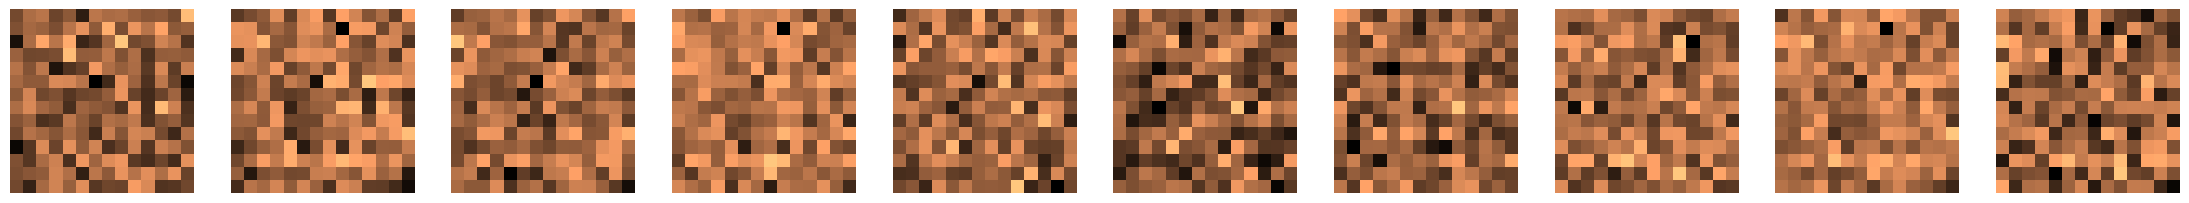

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - c_gp: 0.0498 - c_loss: 0.4501 - c_wass_loss: 0.0016 - g_loss: -0.0035
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0446 - c_loss: 0.4032 - c_wass_loss: 0.0015 - g_loss: -0.0036
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0386 - c_loss: 0.3484 - c_wass_loss: 0.0014 - g_loss: -0.0037
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0368 - c_loss: 0.3323 - c_wass_loss: 0.0012 - g_loss: -0.0036
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_los

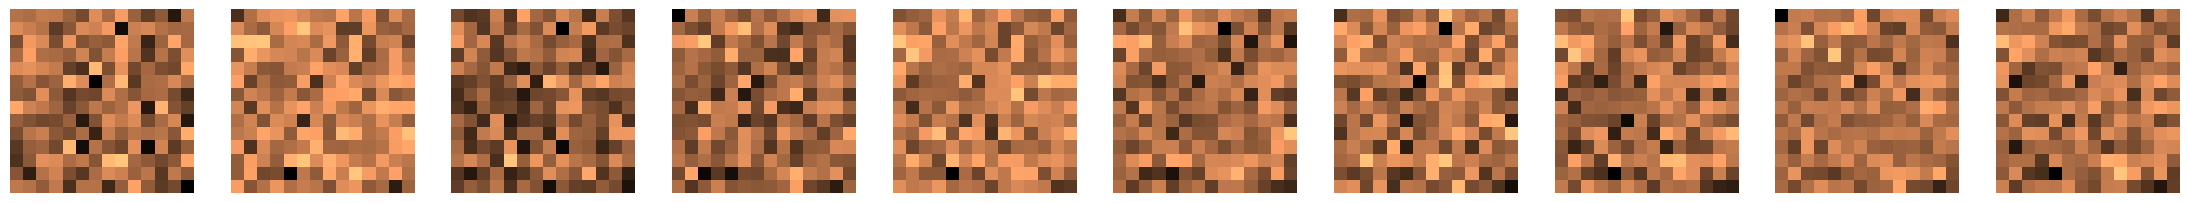

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - c_gp: 0.0340 - c_loss: 0.3067 - c_wass_loss: 7.4743e-04 - g_loss: -0.0035
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0312 - c_loss: 0.2815 - c_wass_loss: 5.2656e-04 - g_loss: -0.0034
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0308 - c_loss: 0.2776 - c_wass_loss: 3.3259e-04 - g_loss: -0.0034
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0310 - c_loss: 0.2788 - c_wass_loss: 1.0585e-04 - g_loss: -0.0034
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e

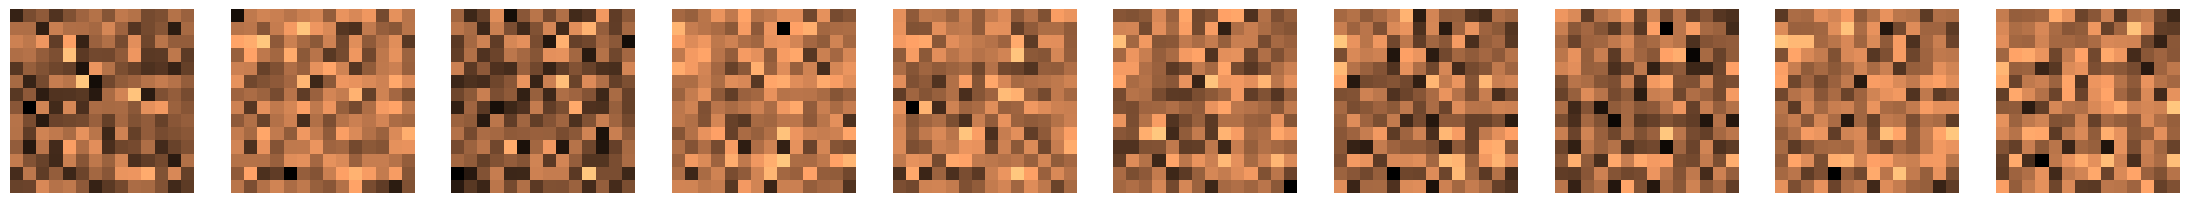

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - c_gp: 0.0285 - c_loss: 0.2567 - c_wass_loss: -1.8231e-04 - g_loss: -0.0034
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0274 - c_loss: 0.2464 - c_wass_loss: -3.3163e-04 - g_loss: -0.0034
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0270 - c_loss: 0.2422 - c_wass_loss: -4.4987e-04 - g_loss: -0.0033
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0275 - c_loss: 0.2470 - c_wass_loss: -5.8344e-04 - g_loss: -0.0034
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - c_gp: 0.0000e+00 - c_loss: 0.0

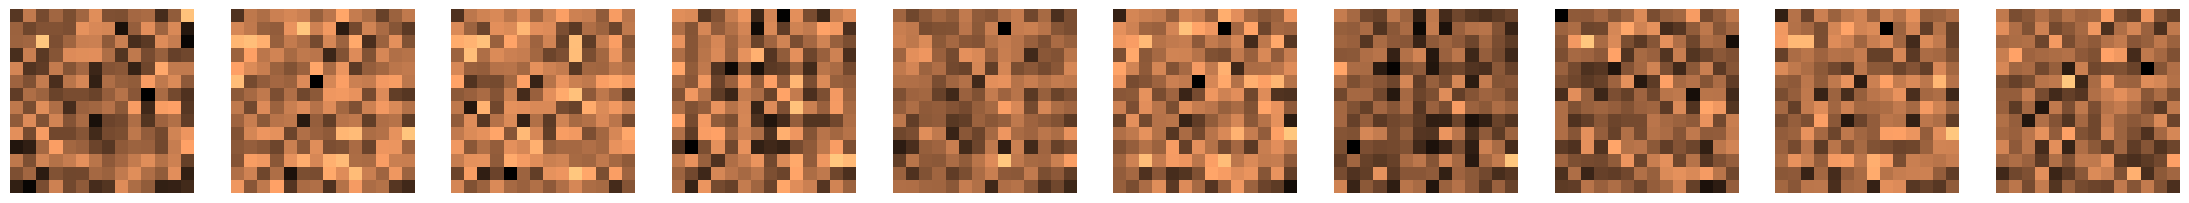

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - c_gp: 0.0259 - c_loss: 0.2319 - c_wass_loss: -8.1312e-04 - g_loss: -0.0034
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0267 - c_loss: 0.2395 - c_wass_loss: -9.1048e-04 - g_loss: -0.0035
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0245 - c_loss: 0.2192 - c_wass_loss: -0.0010 - g_loss: -0.0035  
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0244 - c_loss: 0.2187 - c_wass_loss: -0.0011 - g_loss: -0.0036
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+0

2024-09-17 19:33:10.996190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7144270009558378177


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0238 - c_loss: 0.2128 - c_wass_loss: -0.0012 - g_loss: -0.0036
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 61/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - c_gp: 0.0246 - c_loss: 0.2203 - c_wass_loss: -0.0013 - g_loss: -0.0036

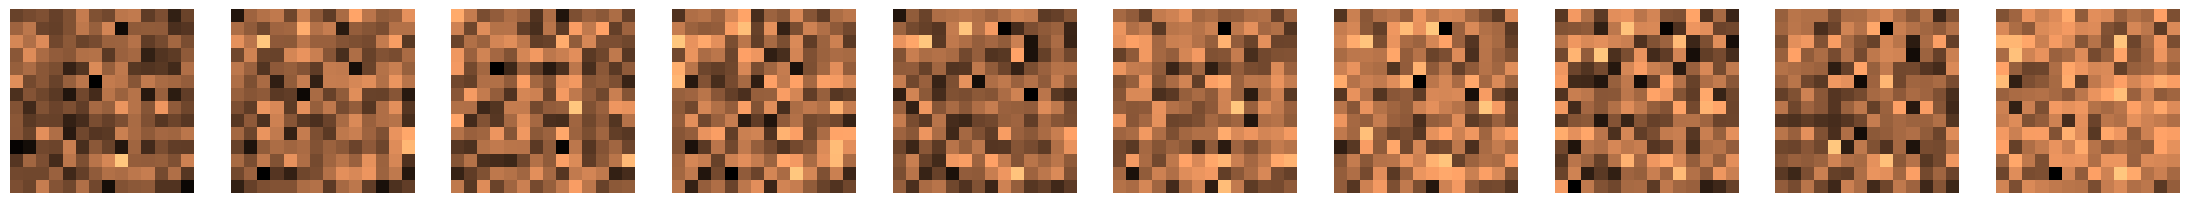

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - c_gp: 0.0246 - c_loss: 0.2205 - c_wass_loss: -0.0013 - g_loss: -0.0036
Epoch 62/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 63/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0247 - c_loss: 0.2206 - c_wass_loss: -0.0013 - g_loss: -0.0037
Epoch 64/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 65/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0251 - c_loss: 0.2243 - c_wass_loss: -0.0014 - g_loss: -0.0037
Epoch 66/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 67/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0242 - c_loss: 0.2159 - c_wass_loss: -0.0015 - g_loss: -0.0038
Epoch 68/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass

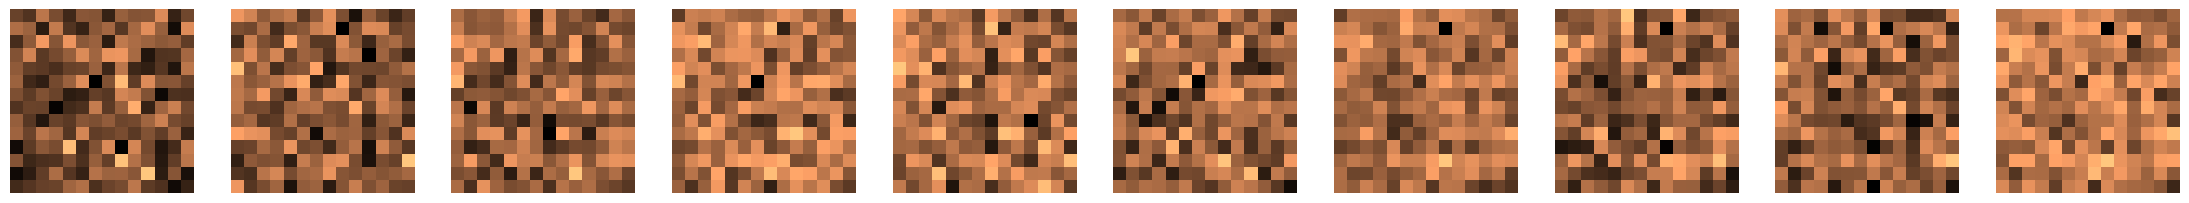

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - c_gp: 0.0232 - c_loss: 0.2075 - c_wass_loss: -0.0016 - g_loss: -0.0038
Epoch 72/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 73/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0229 - c_loss: 0.2042 - c_wass_loss: -0.0017 - g_loss: -0.0039
Epoch 74/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 75/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0230 - c_loss: 0.2049 - c_wass_loss: -0.0018 - g_loss: -0.0039
Epoch 76/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 77/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0231 - c_loss: 0.2063 - c_wass_loss: -0.0019 - g_loss: -0.0040
Epoch 78/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass

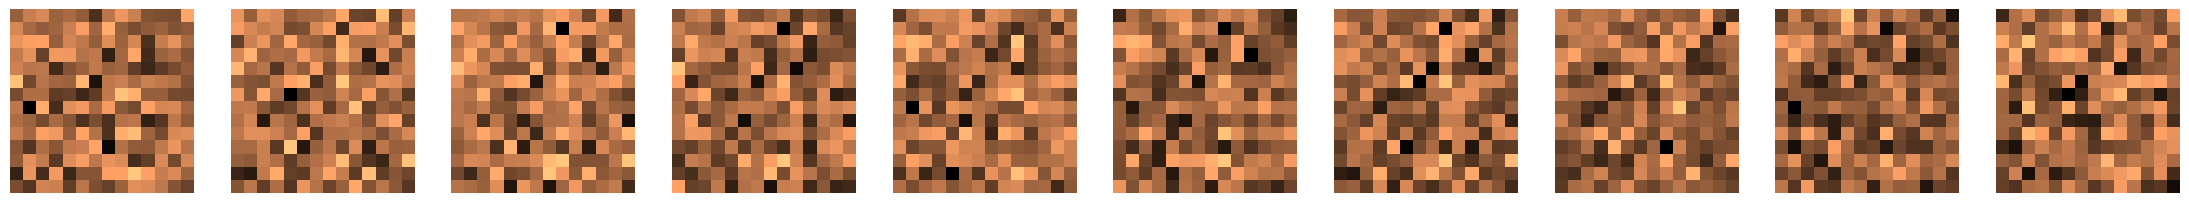

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - c_gp: 0.0227 - c_loss: 0.2020 - c_wass_loss: -0.0020 - g_loss: -0.0040
Epoch 82/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 83/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0210 - c_loss: 0.1870 - c_wass_loss: -0.0020 - g_loss: -0.0041
Epoch 84/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 85/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0214 - c_loss: 0.1901 - c_wass_loss: -0.0021 - g_loss: -0.0041
Epoch 86/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 87/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0209 - c_loss: 0.1856 - c_wass_loss: -0.0021 - g_loss: -0.0042
Epoch 88/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass

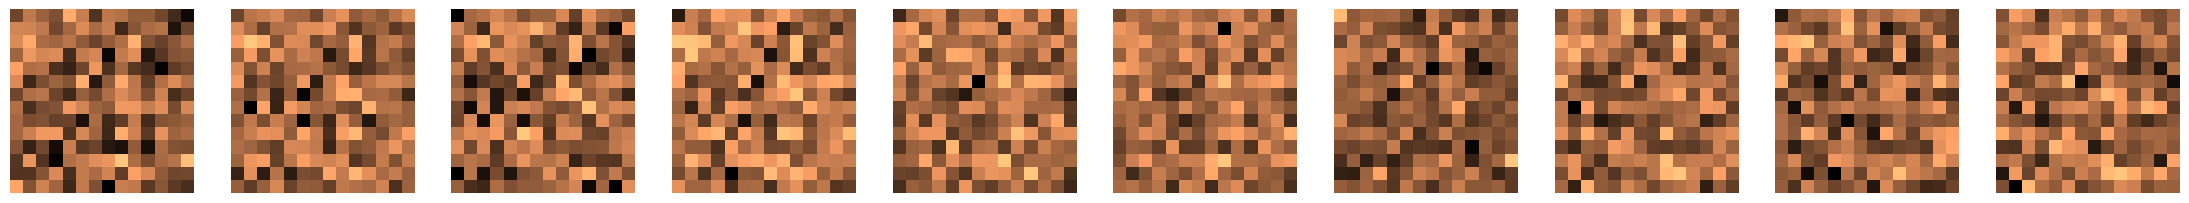

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - c_gp: 0.0212 - c_loss: 0.1884 - c_wass_loss: -0.0023 - g_loss: -0.0042
Epoch 92/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 93/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - c_gp: 0.0213 - c_loss: 0.1895 - c_wass_loss: -0.0023 - g_loss: -0.0042
Epoch 94/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 95/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - c_gp: 0.0210 - c_loss: 0.1870 - c_wass_loss: -0.0024 - g_loss: -0.0043
Epoch 96/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 97/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0206 - c_loss: 0.1826 - c_wass_loss: -0.0024 - g_loss: -0.0043
Epoch 98/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass

In [116]:
if TRAIN:
    dataset = tf.data.Dataset.from_tensors(X.astype("float32")).repeat(REPEAT_DATA)

    wgangp.fit(
        dataset,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


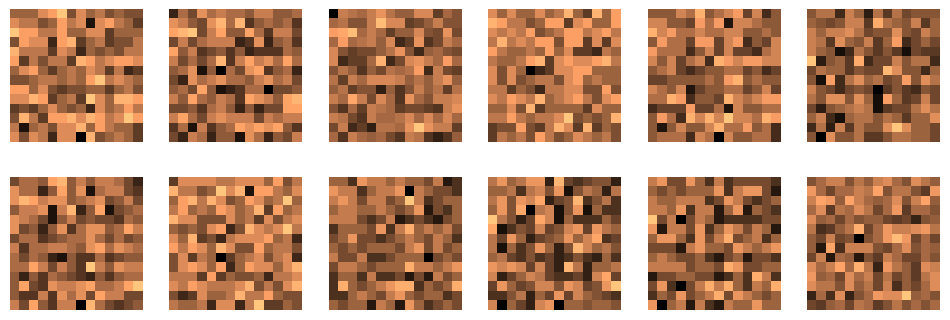

In [117]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

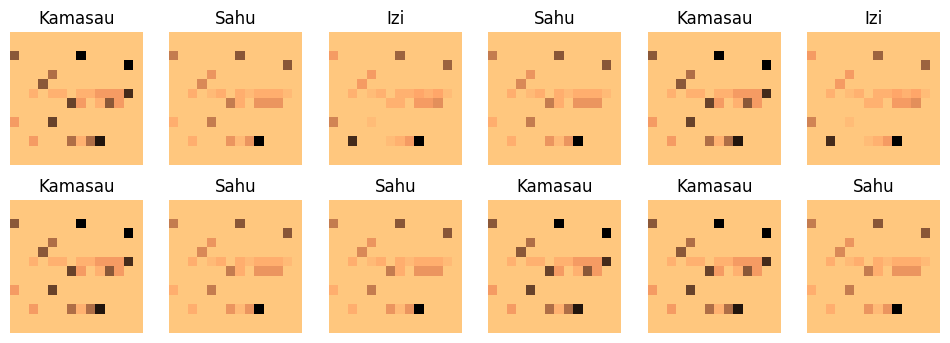

9.765816326530611

In [118]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.mean(closest_diff)

In [119]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((852, 14, 14, 1), (0,))

In [120]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

param_df.head(5)

ID  \
Area      Chapter                                   
Phonology Consonant Inventories                1A   
          Vowel Quality Inventories            2A   
          Consonant-Vowel Ratio                3A   
          Voicing in Plosives and Fricatives   4A   
          Voicing and Gaps in Plosive Systems  5A   

                                                                              Name  
Area      Chapter                                                                   
Phonology Consonant Inventories                              Consonant Inventories  
          Vowel Quality Inventories                      Vowel Quality Inventories  
          Consonant-Vowel Ratio                              Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives    Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems  Voicing and Gaps in Plosive Systems